# TODO
#### analyzing correlation between edu spending and voter turnout.
I have the script but its using pandas and its not scalable yet. And it's not working right now.

In this script, we will analyze the connection between spending and voter turnout, as well as generally analyze turnout level on election results.

Let's get/initialize a spark session and then read in the `data/merged_data.csv`

In [49]:
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.window import Window
import os, re

spark = SparkSession.builder.appName("PredictWinningParty_Scalable").getOrCreate()

# Load a merged CSV file into Spark (this file should contain "Wahlbeteiligung" and "Winning_Party")
merged_data = spark.read.csv("data/merged_data.csv", header=True, inferSchema=True)

First, we will analyze the correlation between education spending and voter turnout & party preference

At first, let's dynamically get the election years.

In [50]:
years = []
# iterate through XLSX files in folder
for filename in os.listdir("data"):
    if filename.endswith(".xlsx"):
        match = re.compile(r'\d{4}').search(filename) # match years in filenames
        if match:
            years.append(int(match.group()))

years.sort()

In [64]:
# ensure Wahlbeteiligung is a float
merged_data = merged_data.withColumn("Wahlbeteiligung", col("Wahlbeteiligung").cast("float"))

# get total spending / municipality
total_spending = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.sum("Spending_Summe").alias("Total_Spending_Summe"))

# get avg voter turnout / municipality
voter_turnout = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.avg("Wahlbeteiligung").alias("Avg_Turnout"))

# compute spending leading up to each election
def get_last_election_year(year):
    return max([y for y in years if y < year], default=None)
get_last_election_year_udf = F.udf(get_last_election_year)

merged_data = merged_data.withColumn("Last_Election_Year", get_last_election_year_udf(col("Year")))

# filter spending after last election year
recent_spending = merged_data.filter(col("Year") > col("Last_Election_Year")) \
    .groupBy("Municipality_Lowercase") \
    .agg(F.sum("Spending_Summe").alias("Recent_Spending_Summe"))

spending_vs_turnout = total_spending.join(voter_turnout, on="Municipality_Lowercase")
recent_spending_vs_turnout = recent_spending.join(voter_turnout, on="Municipality_Lowercase")

# compute correlations
correlation_total = spending_vs_turnout.stat.corr("Total_Spending_Summe", "Avg_Turnout")
correlation_recent = recent_spending_vs_turnout.stat.corr("Recent_Spending_Summe", "Avg_Turnout")

print(f"\nCorrelation (Total Spending vs. Voter Turnout): {correlation_total:.3f}")
print(f"Correlation (Spending Leading up to Election vs. Voter Turnout): {correlation_recent:.3f}\n")

# get party wins count for each municipality
party_wins = merged_data.groupBy("Municipality_Lowercase", "Winning_Party").count()
# party_wins.show(5) # for debug/demonstration

# merge total spending with party wins
spending_vs_party = total_spending.join(party_wins, on="Municipality_Lowercase")

# compute corr. between total spending vs party preference
correlation_party_total = spending_vs_party.stat.corr("Total_Spending_Summe", "count")

# compute corr. btwn recent spending (leading up to election) vs party preference
spending_vs_party_recent = recent_spending.join(party_wins, on="Municipality_Lowercase")
correlation_party_recent = spending_vs_party_recent.stat.corr("Recent_Spending_Summe", "count")

print(f"\nCorrelation (Total Spending vs. Party Wins): {correlation_party_total:.3f}")
print(f"Correlation (Recent Spending Leading to Election vs. Party Wins): {correlation_party_recent:.3f}\n")


Correlation (Total Spending vs. Voter Turnout): -0.172
Correlation (Spending Leading up to Election vs. Voter Turnout): -0.170

+----------------------+-------------+-----+
|Municipality_Lowercase|Winning_Party|count|
+----------------------+-------------+-----+
|             kronstorf|          SPO|    3|
|               pucking|          FPO|    1|
|           v�cklabruck|          OVP|    3|
|  sch�rfling-am-att...|          OVP|    1|
|            altm�nster|          SPO|    2|
+----------------------+-------------+-----+
only showing top 5 rows


Correlation (Total Spending vs. Party Wins): 0.103
Correlation (Recent Spending Leading to Election vs. Party Wins): 0.106



Spending vs. voter turnout correlation is weak and negative.

Possible explanations:
- Voter turnout may be driven by other factors, not just spending.
- Higher spending may be happening in areas with historically low turnout, i.e. it’s compensating for something else (like economic hardship).
- Public spending could be taken for granted, so people don't vote based on it.

Recent spending shows almost the same correlation as total spending, which suggests that spending patterns over time do not significantly shift voter participation.

Spending vs. party wins correlation is weak and positive.

Possible explanations:
- Winning parties may influence spending, rather than the other way around.
    - If a party keeps winning in the same municipalities, they may maintain/increase spending in their strongholds.
    - This would make spending a result of party wins rather than a cause.
- Voters may not directly connect public spending to election results.
    - Spending benefits may be distributed across multiple parties, making it hard to attribute changes to one party’s success.
    - If voters might see education spending as a government duty rather than a political strategy.

Recent spending has almost the same correlation as total spending, which suggests that spending in the short term isn’t much more influential than long-term trends.

Overall, spending has a weak direct linear correlation with voter turnout and party wins, meaning it’s not the main factor affecting elections.

However, in the predictive models, we saw that the total spending feature is important, suggesting it interacts with other variables in nonlinear ways. Spending may still play a role in influencing elections, but it likely works indirectly.

Next, we will produce two visualizations to help us understand the data better. We will try to make this as scalable as possible.

However, please note that while pyspark handles data processing, visualization requires conversion to Pandas (for rendering).

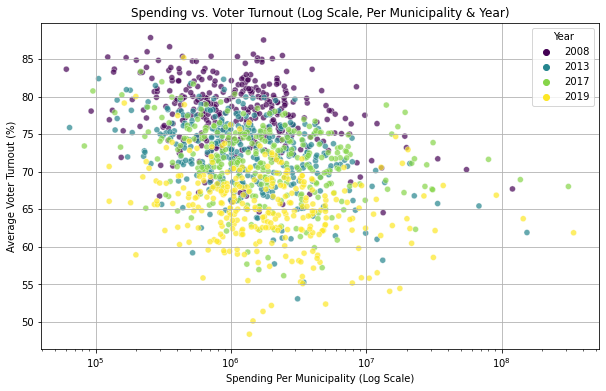

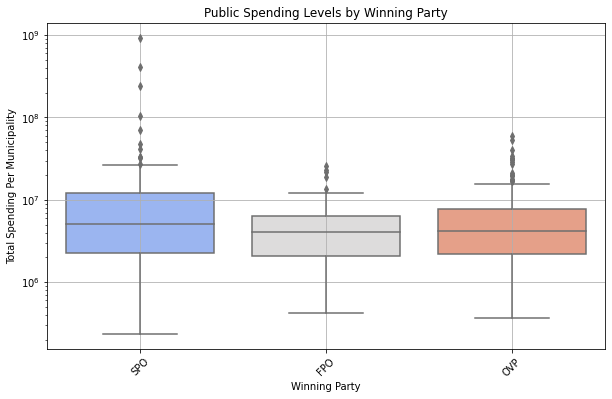

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import numpy as np

# spending vs voter turnout (per municipality, per year)

# aggregate spending per municipality per year
spending_per_municipality = merged_data.groupBy("Municipality_Lowercase", "Year").agg(
    F.sum("Spending_Summe").alias("Spending_Summe"),
    F.avg("Wahlbeteiligung").alias("Avg_Turnout")
).orderBy("Year")

# convert to pandas for visualization
spending_pdf = spending_per_municipality.toPandas()

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=spending_pdf, x="Spending_Summe", y="Avg_Turnout", hue="Year", palette="viridis", alpha=0.7)
ax.set_xscale("log")
plt.xlabel("Spending Per Municipality (Log Scale)")
plt.ylabel("Average Voter Turnout (%)")
plt.title("Spending vs. Voter Turnout (Log Scale, Per Municipality & Year)")
plt.grid(True)
plt.show()

# boxplot of public spending levels by winning party (log scaled)

# compute total spending & dominant party per municipality
spending_vs_party = merged_data.groupBy("Municipality_Lowercase", "Winning_Party").agg(
    F.sum("Spending_Summe").alias("Total_Spending")
).toPandas()

# Plot spending vs. dominant party (boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=spending_vs_party, x="Winning_Party", y="Total_Spending", palette="coolwarm")
plt.yscale("log")
plt.xlabel("Winning Party")
plt.ylabel("Total Spending Per Municipality")
plt.title("Public Spending Levels by Winning Party")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Observations:**
    
Graph 1 shows little trend between educations spending and voter turnout. It is visible that voter turnouts are roughly consistent in each election (as color-coded elections seem to form horizontal clusters), suggesting that voter turnout might be influenced by other factors, such as public morale/enthusiasm to vote.

Graph 2 shows us that the most variation in education spending is in municipalities the SPÖ won, and the least in those the FPÖ won. Additionally, the cities with the highest public spendings seem to be won by the SPÖ.
- SPÖ (Social Democratic Party) generally supports strong public spending, especially in education and welfare. This explains why SPÖ-won municipalities show both higher and more variable spending.
- FPÖ (Freedom Party) appeals more to rural, conservative, and anti-establishment voters, often advocating for fiscal restraint and skepticism toward public spending. This likely results in lower and more consistent spending in FPÖ-won municipalities.
- ÖVP (People’s Party) sits between these two, leading to a mid-range spending pattern.

- ### TODO source for these claims about parties